### This script contains the following:

#### 1. Importing  libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

# 1. Importing  libraries and data

In [5]:
# importing libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [6]:
# Configure API key 

quandl.ApiConfig.api_key = 'zUaLhjbeqNxL5zhDjuVZ'

In [7]:
PATH = 'Data'

In [8]:
# Importing the Federal Reserve Economic Data "Consumer Price Index for All Urban Consumers:" variable.

data = quandl.get('FRED/CPIAUCSL')


This data is about Growth, employment, inflation, labor, manufacturing and other US economic statistics from the research department of the Federal Reserve Bank of St. Louis.

In [9]:
data

,Value
Date,
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2021-09-01,274.214
2021-10-01,276.590
2021-11-01,278.524


In [5]:
data.shape

(901, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

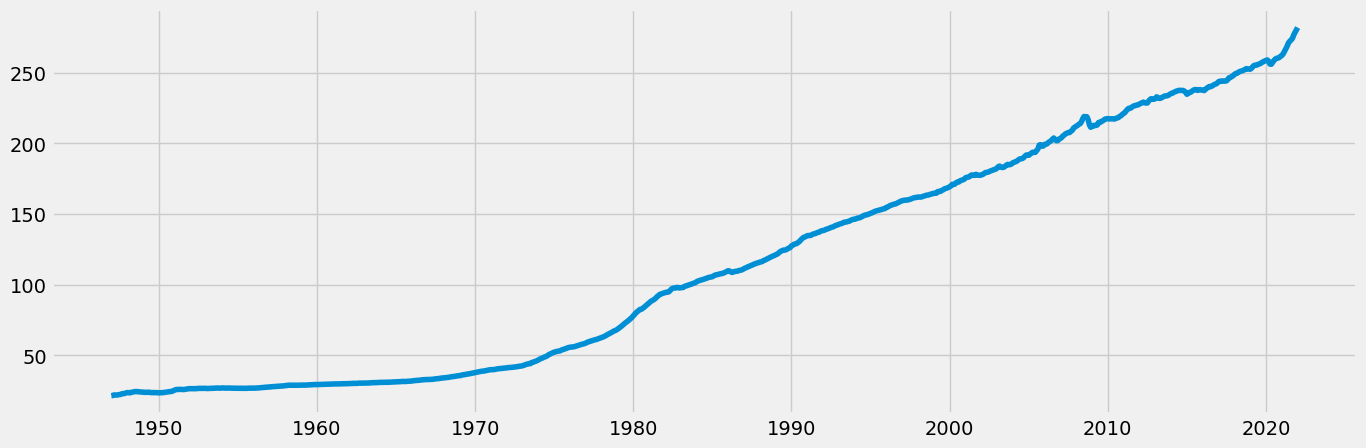

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

 ## 2. Subsetting,wrangling, and cleaning time-series data

In [10]:
data_2 = data.reset_index()

In [21]:
data_sub = data_2.loc[(data_2['Date'] >= '1947-01-01') & (data_2['Date'] < '2021-09-01')]

In [22]:
data_sub.shape

(896, 2)

In [23]:
data_sub.head()


,Date,Value
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [24]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


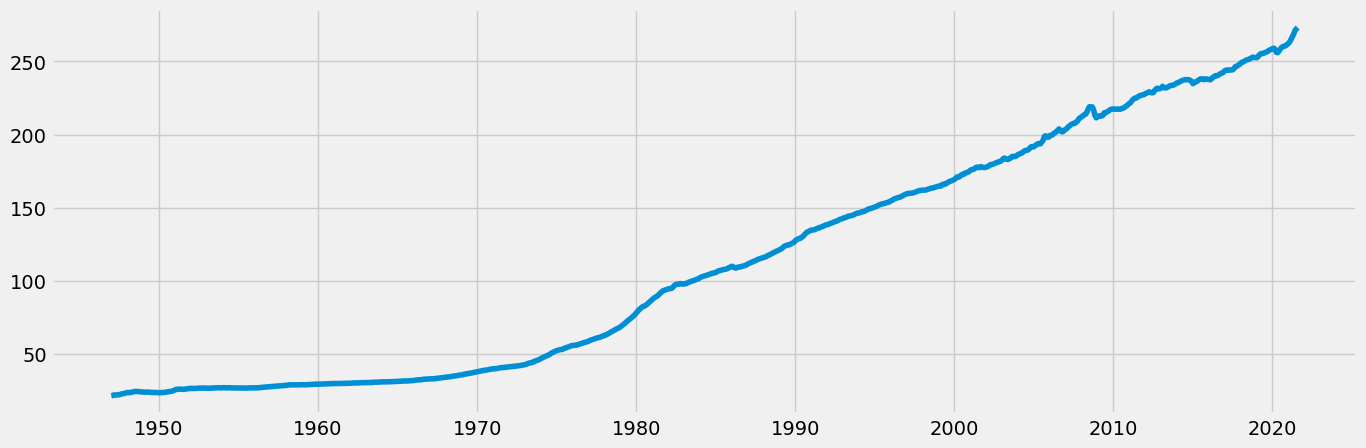

In [25]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [26]:
# Check for missing values 

data_sub.isnull().sum()

Value    0
dtype: int64

# 3. Time-series analysis: decomposition

In [34]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [35]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

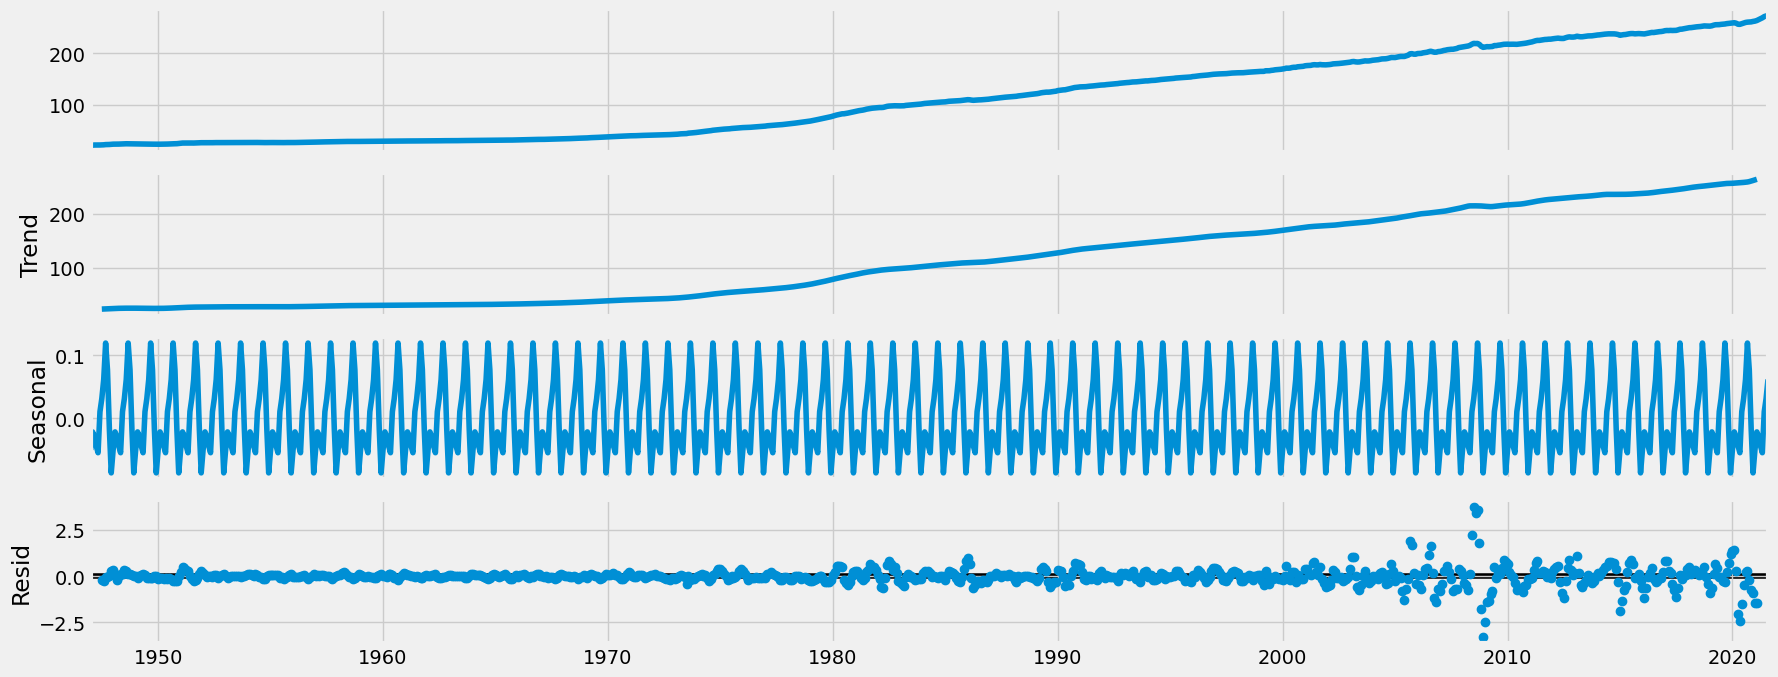

In [36]:
# Plot the separate components

decomposition.plot()
plt.show()

# 4. Testing for stationarity

In [37]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.873352
p-value                          1.000000
Number of Lags Used             15.000000
Number of Observations Used    880.000000
Critical Value (1%)             -3.437803
Critical Value (5%)             -2.864830
Critical Value (10%)            -2.568522
dtype: float64


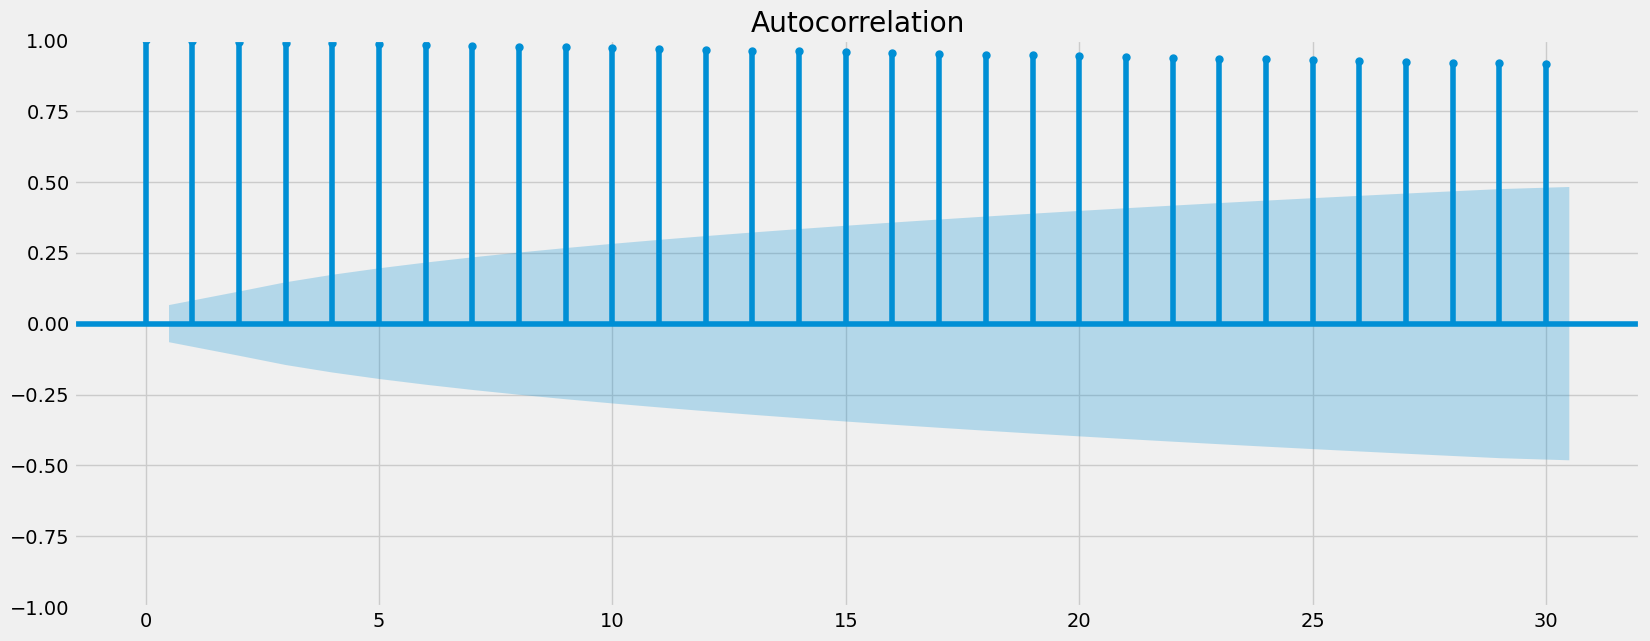

In [38]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# 5. Stationarizing the Federal Reserve Economic Data

In [39]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [40]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.


In [41]:
data_diff.head()


,Value
datetime,
1947-02-01,0.14
1947-03-01,0.38
1947-04-01,0.00
1947-05-01,-0.05
1947-06-01,0.13


In [42]:
data_diff.columns

Index(['Value'], dtype='object')

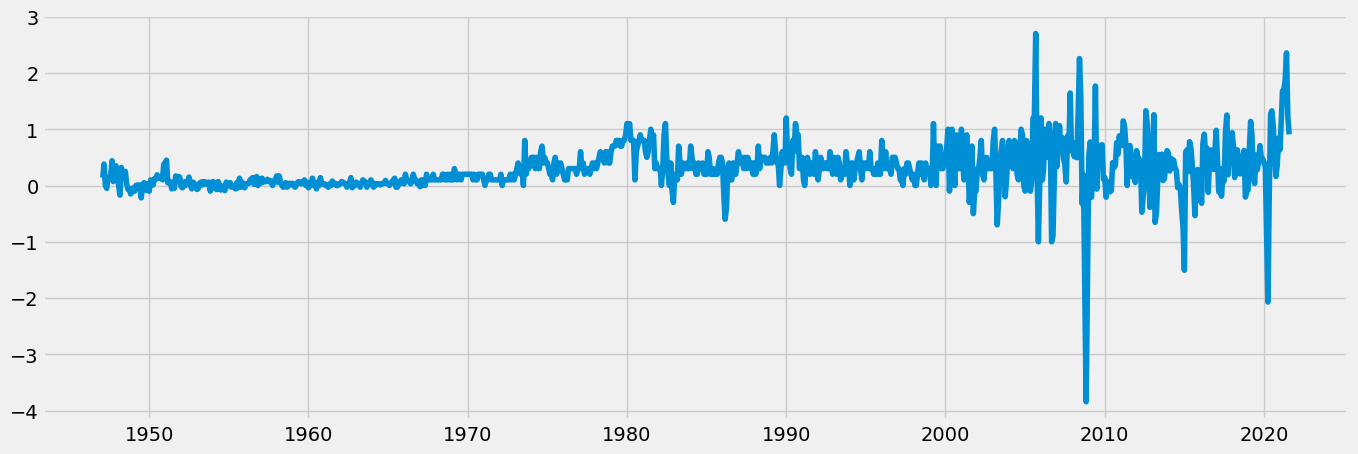

In [43]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [44]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.915338
p-value                          0.043593
Number of Lags Used             16.000000
Number of Observations Used    878.000000
Critical Value (1%)             -3.437820
Critical Value (5%)             -2.864837
Critical Value (10%)            -2.568526
dtype: float64


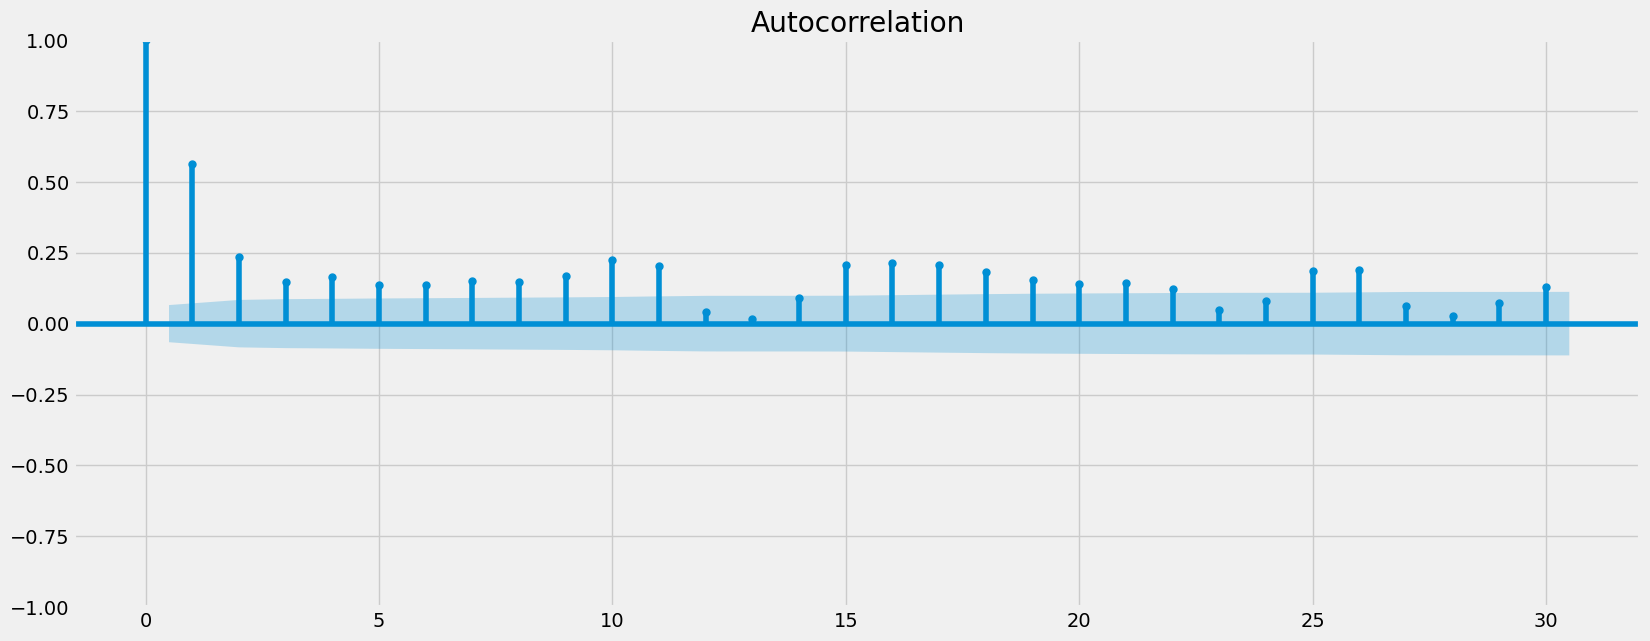

In [45]:
plot_acf(data_diff)
plt.show()

In [11]:
# export the data( Federal Reserve Economic Data "Consumer Price Index for All Urban Consumers)
data.to_csv(os.path.join(PATH, 'Origional Data', ' CPI.csv'))